In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

#upload data

In [10]:
from google.colab import files
uploaded = files.upload()

Saving nearest-earth-objects(1910-2024).csv to nearest-earth-objects(1910-2024).csv


In [4]:
df = pd.read_csv('/content/nearest-earth-objects(1910-2024).csv')
df

<ipython-input-4-1c1a819ed9cb>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/nearest-earth-objects(1910-2024).csv')


,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
...,...,...,...,...,...,...,...,...,...
136175,54341598,(2023 CH3),23.98,0.042516,0.095069,Earth,66598.161306,5.395746e+07,False
136176,3516633,(2010 HA),23.90,0.044112,0.098637,Earth,16319.595599,2.008505e+07,False
136177,3529625,(2010 LM68),20.74,0.189041,0.422708,Earth,40919.716914,2.214991e+07,False
136178,3803907,(2018 HO),26.77,0.011764,0.026305,Earth,62293.166286,7.319412e+07,False


#clean data

In [13]:
df.keys()

Index(['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance', 'is_hazardous'],
      dtype='object')

In [6]:
df.nunique()

,0
neo_id,18105
name,18104
absolute_magnitude,1530
estimated_diameter_min,1530
estimated_diameter_max,1530
orbiting_body,1
relative_velocity,136174
miss_distance,136128
is_hazardous,2


In [7]:
df.isnull().sum().sum()

20

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum().sum()

0

In [14]:
df['avg_diameter'] = (df['estimated_diameter_min'] + df['estimated_diameter_max']) / 2

<ipython-input-14-f71df1c29991>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_diameter'] = (df['estimated_diameter_min'] + df['estimated_diameter_max']) / 2


In [16]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

for col in ['avg_diameter', 'relative_velocity', 'miss_distance']:
    df = remove_outliers(df, col)


In [17]:
# Transform skewed distributions using log transformation
df['log_diameter'] = np.log1p(df['avg_diameter'])
df['log_velocity'] = np.log1p(df['relative_velocity'])
df['log_distance'] = np.log1p(df['miss_distance'])

# Feature Engineering: Add new features
df['diameter_to_distance'] = df['avg_diameter'] / df['miss_distance']
df['kinetic_energy_proxy'] = 0.5 * df['avg_diameter'] * (df['relative_velocity'] ** 2)

#preprocess data


In [28]:
# Relationship between magnitude categories and hazardous status
df['magnitude_category'] = pd.cut(df['absolute_magnitude'], bins=[0, 15, 20, 25, 30, float('inf')],
                                  labels=['Very Bright', 'Bright', 'Medium', 'Faint', 'Very Faint'])
relation_result = pd.crosstab(df['magnitude_category'], df['is_hazardous'], normalize='index')
print("Relationship between magnitude categories and hazardous status:\n", relation_result)


Relationship between magnitude categories and hazardous status:
 is_hazardous           False     True 
magnitude_category                    
Very Bright         0.793319  0.206681
Bright              0.735731  0.264269
Medium              0.853489  0.146511
Faint               1.000000  0.000000
Very Faint          1.000000  0.000000


<ipython-input-28-80d2f393be02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magnitude_category'] = pd.cut(df['absolute_magnitude'], bins=[0, 15, 20, 25, 30, float('inf')],


In [19]:
print("Overview of the data after preprocessing:")
print(df.describe())

Overview of the data after preprocessing:
             neo_id  absolute_magnitude  estimated_diameter_min  \
count  1.243620e+05       124362.000000           124362.000000   
mean   1.717775e+07           22.836842                0.123276   
std    2.262776e+07            2.520213                0.115654   
min    2.002101e+06           18.610000                0.000511   
25%    3.388355e+06           20.810000                0.030942   
50%    3.746619e+06           22.460000                0.085616   
75%    5.402810e+07           24.670000                0.183044   
max    5.446281e+07           33.580000                0.504144   

       estimated_diameter_max  relative_velocity  miss_distance  \
count           124362.000000      124362.000000   1.243620e+05   
mean                 0.275653       50430.066747   4.287346e+07   
std                  0.258611       24066.127172   1.981091e+07   
min                  0.001143         313.448220   5.184013e+04   
25%                

# Data Visualization

In [24]:
df.keys()

Index(['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance', 'is_hazardous', 'avg_diameter', 'log_diameter',
       'log_velocity', 'log_distance', 'diameter_to_distance',
       'kinetic_energy_proxy'],
      dtype='object')

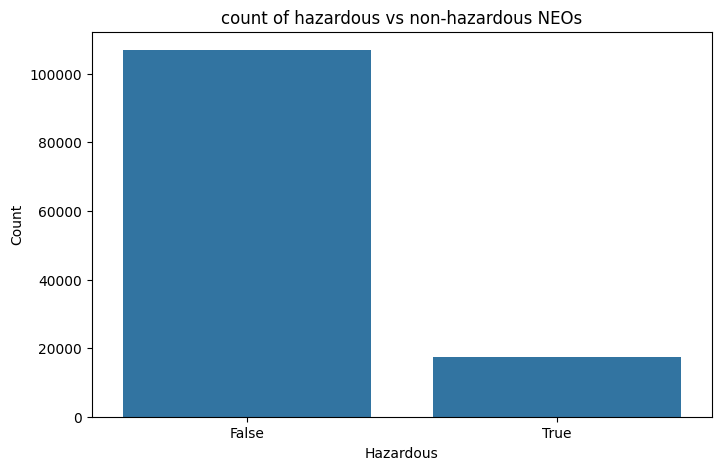

In [34]:
# bar chart: count of hazardous vs non-hazardous
plt.figure(figsize=(8, 5))
sns.countplot(x='is_hazardous', data=df)
plt.title('count of hazardous vs non-hazardous NEOs')
plt.xlabel('Hazardous')
plt.ylabel('Count')
plt.show()

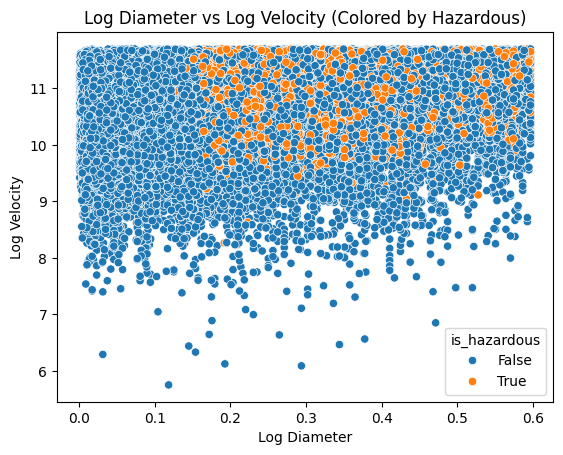

In [40]:
#Scatter Plot - Log Diameter vs Log Velocity by Hazardous (Fixed size parameter)
plt.figure()
sns.scatterplot(x='log_diameter', y='log_velocity', hue='is_hazardous', data=df)
plt.title('Log Diameter vs Log Velocity (Colored by Hazardous)')
plt.xlabel('Log Diameter')
plt.ylabel('Log Velocity')
plt.show()

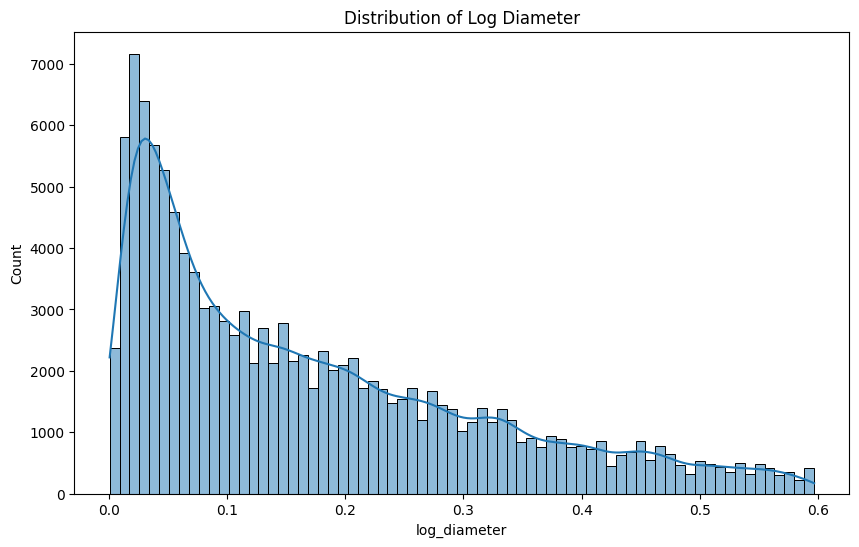

In [27]:
# Histogram: Distribution of Log Diameter
plt.figure(figsize=(10, 6))
sns.histplot(df['log_diameter'], kde=True)
plt.title('Distribution of Log Diameter')
plt.show()

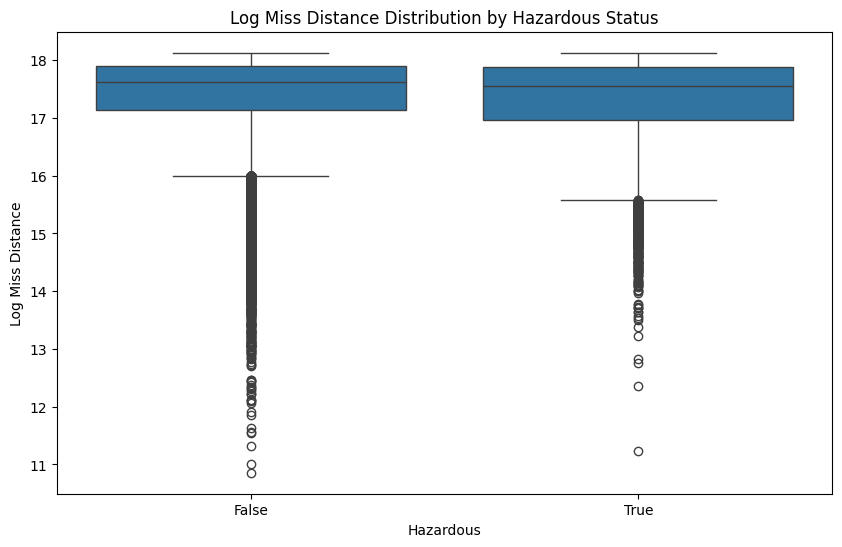

In [42]:
# Box Plot - Log Miss Distance by Hazardous Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_hazardous', y='log_distance', data=df)
plt.title('Log Miss Distance Distribution by Hazardous Status')
plt.xlabel('Hazardous')
plt.ylabel('Log Miss Distance')
plt.show()

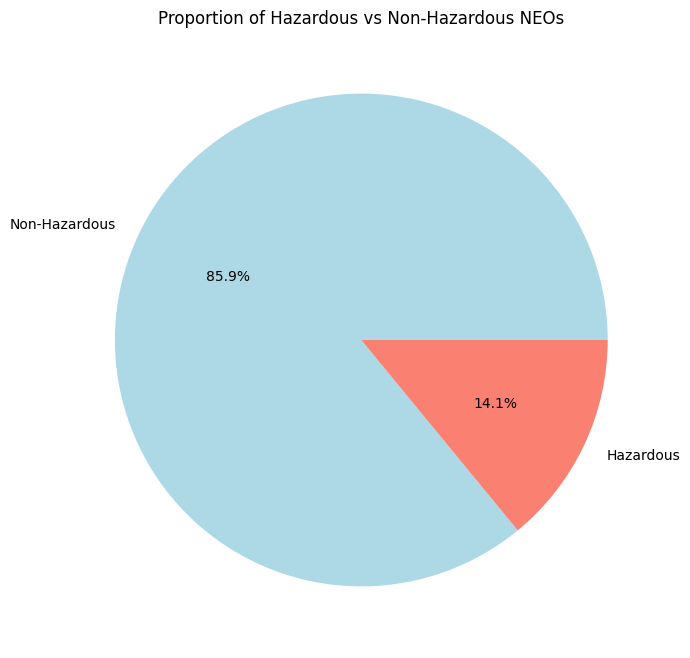

In [45]:
#Pie Chart - Proportion of Hazardous NEOs
plt.figure(figsize=(8, 8))
df['is_hazardous'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Non-Hazardous', 'Hazardous'], colors=['lightblue', 'salmon'])
plt.title('Proportion of Hazardous vs Non-Hazardous NEOs')
plt.ylabel('')
plt.show()

# Prepare Data for ML

In [70]:
# Define X by dropping 'hazardous' and any non-numeric columns
X = df.drop('is_hazardous', axis=1)

In [71]:
# Check column types and remove non-numeric columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X = X[numeric_cols]

In [74]:
# Define target variable y
y = df['is_hazardous'].astype(int)

In [75]:
# Verify X contains only numeric data
print("\nX columns and their types before ML:")
print(X.dtypes)
print("Any non-numeric columns in X?")
print(X.dtypes[X.dtypes != 'float64'][X.dtypes != 'int64'])


X columns and their types before ML:
neo_id                      int64
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
relative_velocity         float64
miss_distance             float64
avg_diameter              float64
log_diameter              float64
log_velocity              float64
log_distance              float64
diameter_to_distance      float64
kinetic_energy_proxy      float64
dtype: object
Any non-numeric columns in X?
Series([], dtype: object)


In [76]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [78]:
# Scale the features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Build Models

In [79]:
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train_res, y_train_res)
lr_pred = lr_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
rf_pred = rf_model.predict(X_test)

In [81]:
# XGBoost with class weights
xgb_model = XGBClassifier(scale_pos_weight=10, random_state=42)
xgb_model.fit(X_train_res, y_train_res)
xgb_pred = xgb_model.predict(X_test)

#evaluation


In [82]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"\nEvaluation of {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

evaluate_model(y_test, lr_pred, "Logistic Regression")
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")


Evaluation of Logistic Regression:
Accuracy: 0.7316
Precision: 0.3358
Recall: 0.9483
F1-Score: 0.4959
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     21410
           1       0.34      0.95      0.50      3463

    accuracy                           0.73     24873
   macro avg       0.66      0.82      0.66     24873
weighted avg       0.90      0.73      0.77     24873


Evaluation of Random Forest:
Accuracy: 0.9293
Precision: 0.6951
Recall: 0.8764
F1-Score: 0.7753
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     21410
           1       0.70      0.88      0.78      3463

    accuracy                           0.93     24873
   macro avg       0.84      0.91      0.87     24873
weighted avg       0.94      0.93      0.93     24873


Evaluation of XGBoost:
Accuracy: 0.7559
Precision: 0.3622
Recall: 0.9893
F1-Score: 0.5302
              precision    recall  f1-score   support



#Feature Importance

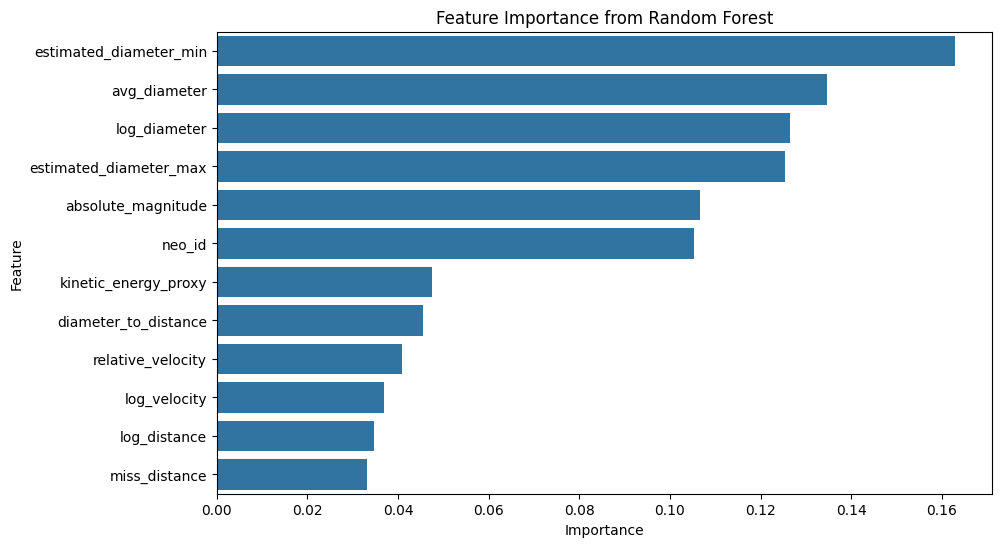

In [83]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.show()